<a href="https://colab.research.google.com/github/tomnyancat/Sapporo-temperature-for-one-year-from-October-2024/blob/main/2024%E5%B9%B410%E6%9C%88%E3%81%8B%E3%82%891%E5%B9%B4%E9%96%93%E3%81%AE%E6%9C%AD%E5%B9%8C%E3%81%AE%E6%B0%97%E6%B8%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 札幌の2024年10月1日〜2025年10月1日の気温

## データに関する注記

本ノートブックで使用している気温データは、気象庁ホームページから取得したものを加工して作成しています。

**出典：** 気象庁ホームページ( https://www.data.jma.go.jp/stats/etrn/index.php )
を加工して作成

気象庁のコンテンツは「公共データ利用規約（第1.0版）( https://www.digital.go.jp/resources/open_data/public_data_license_v1.0 )」に準拠した利用条件の下で利用しています。

---



In [7]:
!pip install matplotlib-fontja

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_fontja



# ========================
# 準備。データクレンジング
# ========================
# いらない最初の5行を読み飛ばす
# このファイルに意味のあるヘッダー行は存在しないので、採番しておく
df_sapporo = pd.read_csv('https://github.com/tomnyancat/Sapporo-temperature-for-one-year-from-October-2024/raw/refs/heads/main/data.csv', encoding='shift_jis', skiprows=5, header=None)

# メタデータはいらないので、必要なものだけ残す
# iloc で必要な列を射影
# copy()で、あたらしいデータフレームdf_sapporo_cleanに入れる
df_sapporo_clean = df_sapporo.iloc[:, [0, 1, 4, 7]].copy()

# インデックス0の行を削除する。インデックスも振り直す
df_sapporo_clean = df_sapporo_clean.drop(index=0).reset_index(drop=True)

#列名を設定し直す
df_sapporo_clean.columns = ['年月日','平均気温','最高気温','最低気温']

#念の為、数値にしておいたほうがいい列を数値型に変換する
for col in ['平均気温', '最高気温', '最低気温']:
    df_sapporo_clean[col] = pd.to_numeric(df_sapporo_clean[col], errors='coerce')

# 型チェック
#print(df_sapporo_clean.info())

print(df_sapporo_clean.head())

# print(df_sapporo_clean)

         年月日  平均気温  最高気温  最低気温
0  2024/10/1  20.4  26.3  15.1
1  2024/10/2  18.5  22.0  15.0
2  2024/10/3  14.7  16.8  12.1
3  2024/10/4  13.7  15.2  12.0
4  2024/10/5  17.2  21.3  12.4


- 日本語が含まれるデータの場合は、読み込み時に「encoding='cp932'」をつける
- header=None はこのファイルには意味のあるヘッダー行はないから、採番してねっていう指示をするもの
- メタデータは気象庁がつけた情報で、いまの私には必要ないから削除
- pandas.DataFrame.iloc は列を番号で指定して射影している
- copy()している理由は、新しいデータフレームに入れちゃったほうがぐちゃぐちゃしないから
- 何らかの理由でNaNが入っていたので、drop(index=0)でゴミを削除
- 型チェックするのは、セルの中に数値以外が入っていないか調べるため。データに文字が混じっていたらobjectが返ってくる
- float64で数字になっているのは確認したが、念の為数値型に型変換する
- pandas.to_numerica() 数値型（float64 または int64）へ強制的に変換する
  - 第1引数:「どの列を変換作業の対象にするか」を指定。現在のループで選ばれた列をこの関数に渡している
  - 第2引数: coerce「強制する」。数値に変換できないデータを見つけたら、エラーで処理を止めずに、NaNに置き換える。

In [8]:
# ========================
# データに異常がないかチェック
# ========================
print("\n--- 札幌の気温：基本統計量（describe()の結果） ---")
# describe()で平均、標準偏差、最大値、最小値などを一括出力
describe_result = df_sapporo_clean[['平均気温', '最高気温', '最低気温']].describe()
print(describe_result)

print(f"観測期間中の最高気温の最大値: {describe_result.loc['max', '最高気温']}℃")
print(f"観測期間中の最低気温の最小値: {describe_result.loc['min', '最低気温']}℃")



--- 札幌の気温：基本統計量（describe()の結果） ---
             平均気温        最高気温        最低気温
count  366.000000  366.000000  366.000000
mean    11.170765   15.186339    7.524044
std     10.297274   11.138755    9.973901
min     -5.200000   -3.400000   -8.500000
25%      0.800000    3.925000   -1.900000
50%     10.950000   15.750000    6.900000
75%     20.600000   25.550000   16.850000
max     29.800000   35.700000   25.600000
観測期間中の最高気温の最大値: 35.7℃
観測期間中の最低気温の最小値: -8.5℃


- 札幌のような夏と冬で気温に差がある場所で、一年間の平均値などを見ても意味はないが、おかしなデータが含まれていないかをチェックするのに、describe()でデータの状態をチェック
- loc[行のラベル, 列のラベル]


In [9]:
# ========================
# 月ごとの分析の準備
# ========================

# 年月日をdatetime型に変換
# errors='coerce'で、もし日付として解釈できない値があったらNaNにする
df_sapporo_clean['年月日'] = pd.to_datetime(df_sapporo_clean['年月日'], errors='coerce')

# 新しい列 Month を作成し、年月日から「月」だけを抽出する
df_sapporo_clean['Month'] = df_sapporo_clean['年月日'].dt.month

# headを確認
#print(df_sapporo_clean.head())

# データの型を確認
#print("\n------")
#print(df_sapporo_clean.info())
#print("\n------")

# ========================
# 月ごとの平均気温を計算
# ========================
print("\n--- 月別平均気温の計算 ---")
# 'Month'でグループ化し、各気温の平均値を計算する
monthly_avg = df_sapporo_clean.groupby('Month')[['平均気温', '最高気温', '最低気温']].mean()
print(monthly_avg)


--- 月別平均気温の計算 ---
            平均気温       最高気温       最低気温
Month                                 
1      -1.245161   1.496774  -3.774194
2      -0.903571   2.375000  -4.442857
3       2.022581   5.280645  -1.287097
4       8.513333  12.953333   5.156667
5      14.890323  20.174194  10.512903
6      20.560000  25.830000  16.476667
7      25.848387  30.419355  22.216129
8      24.690323  28.816129  21.261290
9      20.743333  25.216667  16.610000
10     14.006250  18.434375   9.212500
11      5.970000   9.566667   2.040000
12     -1.948387   0.741935  -4.577419


- groupby('Month')で同じ数値が入っているものをグループ化
- それらのグループ（つまり月）の、平均気温、最高気温、最低気温の平均をだす

# 2024年10月〜2025年10月の札幌の月ごとの平均気温からわかること

- 今シーズンは、12月が寒かった。1月より寒いとかは珍しい
- 4月5月は例年通りな感じだったが、6月から8月までありえんくらい暑かった



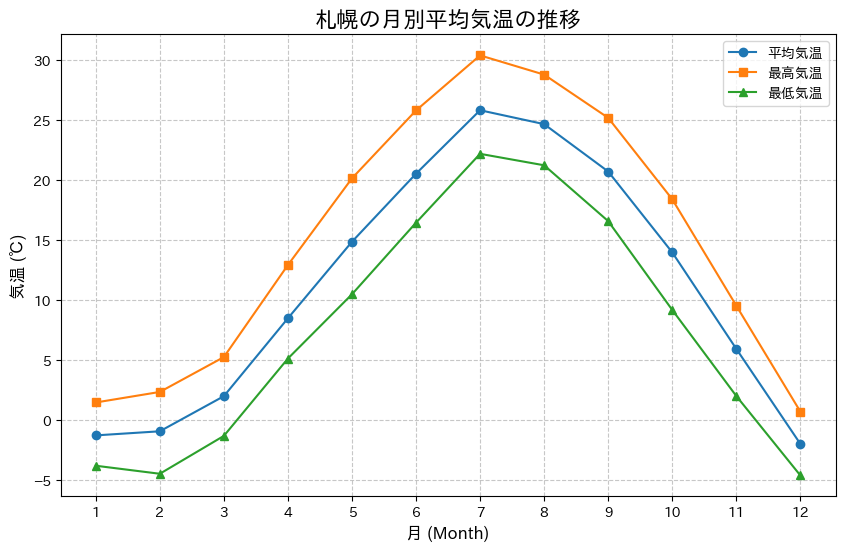

In [10]:

# ========================
# データの可視化
# ========================

# グラフの作成
plt.figure(figsize=(10, 6)) # グラフサイズの設定

# 折れ線グラフを描画
plt.plot(monthly_avg.index, monthly_avg['平均気温'], marker='o', label='平均気温')
plt.plot(monthly_avg.index, monthly_avg['最高気温'], marker='s', label='最高気温')
plt.plot(monthly_avg.index, monthly_avg['最低気温'], marker='^', label='最低気温')

# グラフの装飾
plt.title('札幌の月別平均気温の推移', fontsize=16)
plt.xlabel('月 (Month)', fontsize=12)
plt.ylabel('気温 (℃)', fontsize=12)
plt.xticks(monthly_avg.index) # x軸の目盛りを月（1〜12）に設定
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# グラフを表示
plt.show()

- plt は変数の代入先ではなく、matplotlib.pyplot というモジュール全体を指している。つまり、現在のグラフにデータを追加している状態
- matplotlib.pyplot.figure
  - figsize で大きさを決めるが、単位はインチ
- matplotlib.pyplot.plot
  - 第1引数: monthly_avg.index (X軸データ)
    - index には、1, 2, 3, ... 12 という月の数値が入っている。横軸に1、2、3...が並ぶ
  - 第2引数: monthly_avg['平均気温'] (Y軸データ)
    - monthly_avg のデータフレームから抽出した各月の平均気温の値をつかって、縦軸に「気温（℃）」の値を配置する
  - marker='o' (マーカー形状の指定)
  - label='平均気温' (凡例の名称)
- plt.title() (グラフのタイトル)
  -グラフの最上部に表示されるタイトルを設定する
- plt.xlabel() / plt.ylabel() (軸のラベル)
- plt.xticks() (X軸の目盛り)
  - monthly_avg.index を指定して、月のところにメモリが来るように設定
- plt.grid() (グリッド線)
- plt.legend() (凡例)
  - plt.plot() で label='...' と指定した凡例を、実際にグラフ上に表示するように明示。これを書かないと出ない
- plt.show()
  - matplotlib は、plt.show() が実行されるまで、描画した内容をメモリの中に保持している。

# 分析

- 12月と1月については、折れ線グラフ的には些細に見えるがやはり12月のほうが寒かった（どの平均値も1月より値が小さい）
- 6,7,8,9月の平均気温が20度を上回っていた
- 過去数年間のデータを出さないと客観的には言えないが、札幌で6月9月に平均気温が20度を超えるのは気温が高い
- 7月8月に至っては、最低気温の平均気温が20℃超え。夜になれば涼しいという定説が覆っていると思われる

# さらに見たいこと

- 道民からすると25℃でも暑いと思ってるので、各月の25度以上と30℃以上の棒グラフが並んだやつ出してみたい

In [11]:

# ========================
# 暑すぎてやばい日の件数分析（真夏日）
# ========================
print("\n--- 暑すぎてやばい日の件数（真夏日カウント） ---")
# 真夏日（最高気温30℃以上）のデータを抽出
# ブールインデックス参照。
extreme_heat_days = df_sapporo_clean[df_sapporo_clean['最高気温'] >= 30]

# 月ごとに真夏日の日数をカウント
monthly_extreme_counts_30c = extreme_heat_days.groupby('Month').size()
print("月別 真夏日（最高気温30℃以上）の日数:")
print(monthly_extreme_counts_30c)



--- 暑すぎてやばい日の件数（真夏日カウント） ---
月別 真夏日（最高気温30℃以上）の日数:
Month
6     6
7    18
8    11
dtype: int64


**extreme_heat_days = df_sapporo_clean[df_sapporo_clean['最高気温'] >= 30]**

- こうやって条件式を書くと、ブールになる
- df_sapporo_clean の全データ（全行）に対して、「あなたの最高気温なんだけどさ、30℃以上ですか？YesまたはNoで答えて」と聞いてまわりメモをして、各行に True または False を書いた紙を押し付けていく
- そうして新しいデータフレーム extreme_heat_days には、Yesと答えた日だけが抽出され、格納される

**monthly_extreme_counts_30c = extreme_heat_days.groupby('Month').size()**

- まず、最高気温が 30℃ 以上のデータ（行）だけが入った長いリスト（extreme_heat_days）がある
- groupby('Month') の命令により、Month 列の値を見て、その数だけ箱を用意して、データを仕分ける
- データをすべて仕分けられたら、.size() を実行して各箱の中に、データ（行）が何個入っているかを数える
- 結果、月ごとの真夏日の日数（件数）が返ってくる

In [12]:
# ========================
# 暑すぎてやばい日（夏日・真夏日カウント）
# ========================
print("\n--- 暑すぎてやばい日（夏日・真夏日カウント） ---")

# 夏日（最高気温25℃以上）のデータを抽出
hot_days_25c = df_sapporo_clean[df_sapporo_clean['最高気温'] >= 25]
# 月ごとに夏日の日数をカウント
monthly_hot_counts_25c = hot_days_25c.groupby('Month').size()

# グラフ描画のためのデータフレームの準備
all_months = pd.DataFrame(index=range(1, 13)) # 1月から12月までのインデックスを作成

# 夏日と真夏日のSeries（25℃以上の日数の集計結果と30℃以上の日数の集計結果）をデータフレーム化し、結合時の欠損（データがない月）を0で埋める
# データが存在する月（5月〜9月など）だけが入った、データ本体
monthly_extreme_summary = pd.DataFrame({
    '25℃以上': monthly_hot_counts_25c,
    '30℃以上': monthly_extreme_counts_30c
}).fillna(0) # どちらかのデータがない月は0にする

# グラフ描画用に、1月から12月まで全ての月が含まれるように調整
monthly_extreme_summary = all_months.join(monthly_extreme_summary, how='left').fillna(0)


print("\n月別 夏日（最高気温25℃以上）と真夏日（最高気温30℃以上）の日数:")
print(monthly_extreme_summary)


--- 暑すぎてやばい日（夏日・真夏日カウント） ---

月別 夏日（最高気温25℃以上）と真夏日（最高気温30℃以上）の日数:
    25℃以上  30℃以上
1     0.0    0.0
2     0.0    0.0
3     0.0    0.0
4     0.0    0.0
5     4.0    0.0
6    17.0    6.0
7    31.0   18.0
8    29.0   11.0
9    15.0    0.0
10    1.0    0.0
11    0.0    0.0
12    0.0    0.0


- データフレーム、all_months と monthly_extreme_summary を分けるのは、一気に入れようとするとデータが入っていない月のことを考えるのが大変だから
- monthly_extreme_summaryってすくなくとも25℃以上の日があった月しか入ってないと思うのだが、どうしてインデックス（つまり月）しかない表とこんなに簡単にくっつけられるんだろう。例えるなら、1月から12月までが書かれている模造紙が合って、その上に5月から9月とかまでが入った別の紙を貼ってるイメージ
  - これは、模造紙の方に 1,2,3,...,12ってインデックスがあって、夏日真夏日の紙の方には 5,6,7,8,9 っていうインデックスがあるけれど、自動で合わせて貼ってくれるから
  - how='left' は LEFTJOIN
  - left は メソッドを呼び出しているデータフレームのこと
  - right は引数として渡されているデータフレームのこと
- fillna(0) はNaNになっているところを0埋めしている

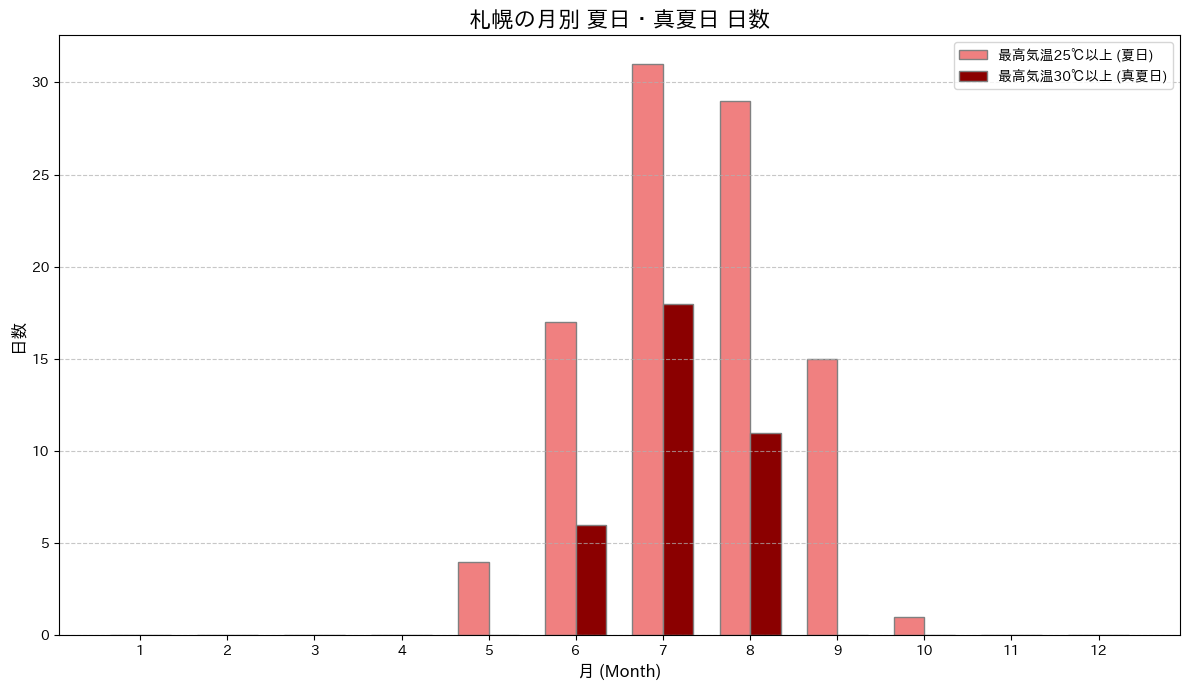

In [13]:
# ========================
# データの可視化
# ========================
plt.figure(figsize=(12, 7))

# 棒グラフの描画
bar_width = 0.35
# monthly_extreme_summaryは、夏日（最高気温25℃以上）と真夏日（最高気温30℃以上）の日数
months = monthly_extreme_summary.index

r1 = np.arange(len(months))
r2 = [x + bar_width for x in r1]

plt.bar(r1, monthly_extreme_summary['25℃以上'], color='lightcoral', width=bar_width, edgecolor='grey', label='最高気温25℃以上 (夏日)')
plt.bar(r2, monthly_extreme_summary['30℃以上'], color='darkred', width=bar_width, edgecolor='grey', label='最高気温30℃以上 (真夏日)')

# グラフの装飾
plt.xlabel('月 (Month)', fontsize=12)
plt.ylabel('日数', fontsize=12)
plt.title('札幌の月別 夏日・真夏日 日数', fontsize=16)
plt.xticks([r + bar_width/2 for r in range(len(months))], months) # x軸の目盛りを中央に
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout() # グラフ要素が重ならないように自動調整

plt.show()


- months = monthly_extreme_summary.index
  - monthes には、indexが入ってるってことだから、1〜12が入ってる。やっぱりforを回さなくてもいいのが不思議
- r1 = np.arange(len(months))
  - NumPyを使っているってことは、数学関係なんだと思うけど、len(monthes)から推測されるのは長さはmonthes分ってことかな
    - np.arrange()は「指定された数（終点）までの、等間隔な数値の配列」を生成する。monthes を引数に入れてるから、12になる
    - np.arange(12) が実行されると、結果は [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] という12個の数字の配列になる
  - r1 は、12ヶ月分の棒グラフを配置するための、座標リストを渡しているんだけど、感覚としてはbarを起きたい個数を渡しているように見える。位置調整は matplotlib がやってくれるから
- r2 = [x + bar_width for x in r1]
  - bar_width と r1を使って配列を作っている
  - r2 は、2つ目の棒 (30℃以上) の位置を計算している
  - 1月の25℃以上の棒は X=0 に立つ
  - 1月の30℃以上の棒は X=0 + 0.35 に立つ
- 不思議なのは、r1でxを指定すれば、グラフ上で0とする場所とかにかってに配置してくれるのが不思議
- plt.xticks([r + bar_width/2 for r in range(len(months))], months)
  - 複合棒グラフを「月が棒の中央に来る、見やすいグラフ」にしている
  - 棒グラフの plt.bar は、X軸上の位置を指定すると、その位置を中心として棒を描画する
  - 「月」のラベルは、2本の棒が並んだ真ん中に表示されてほしい
  - plt.xticks(months)って書くと、r1つまり25℃以上の方をX軸のデフォルトとみなす
  - だから意図的に r + bar_width/2 (つまり、最初の棒の中心から、さらに棒の幅の半分だけ右) にずらすと、棒と棒の間に目盛りの数字が来る
  - ここでわかりにくいのは、棒グラフをずらしているんじゃなくて、目盛りの数字が移動していること、かつ、自動で均等配置されるので、基準の場所がわからないこと

# 分析

- 6月に真夏日があるのがエグい
- 夏が来るのが早く、終わるのも遅い。（6月〜9月の4ヶ月）北海道には半年間の冬があるが、夏が4ヶ月もあると春と秋が1ヶ月しか無い
- 四季ではなく二季になりつつあるのでは？
- 7月はまるっと一ヶ月暑かったってことは、6月後半から8月頭まで約2ヶ月ずっと暑かったのであろう
- 私が子供の頃は7月での20℃に届かない日が普通だったので、地球温暖化は間違いなく進行していると思う